In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Ensamble de modelos y *random forest*

En un ensamble de modelos combinamos varios modelos para mejorar las predicciones (clasificación o regresión) de los modelos individuales.

Un grupo de modelos así se llama un **ensamble de modelos** y la técnica se llama *ensemble learning*.

Por ejemplo:

* Se puede entrenar un grupo de árboles de decisión, cada uno en un subconjunto aleatorio del conjunto de entrenamiento.
* Para realizar predicciones, obtenemos las predicciones de cada árbol y la predicción final es la clase que obtiene la mayoría de los votos.
* Este ensamble de modelos se llama un *random forest*.
* Aunque es un método simple, es uno de los algoritmos más poderosos de *machine learning*.

### Clasificadores con votos

| ![](figures_ensamble/fig7-1.png) |
|----------------------------------|
| Un grupo de clasificadores diversos. |

| ![](figures_ensamble/fig7-2.png) |
|----------------------------------|
| Clasificador por votos (*hard voting*) |

Un clasificador por votos a veces logra un *accuracy* mayor que el mejor clasificador del ensamble!

De hecho, incluso si cada clasificador es **débil** (es solo ligeramente mejor que adivinanzas al azar), el ensamble puede ser un clasificador **fuerte** (si hay muchos clasificadores y son muy diversos).

Por ejemplo: $1000$ clasificadores que son correctos 51% del tiempo. Usando la clase votado por la mayoría se puede esperar un rendimiento de 75%.

Este es verdad sólo si todos los clasificadores son independientes, y cometen errores sin correlaciones. Pero ya que están entrenados usando los mismos datos habrán correlaciones. Así que el rendimiento será un poco menor.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [5]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                          ('rf', rnd_clf), ('svc', svm_clf)],
                              voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Si los clasificadores pueden dar la probabilidad para las clases (tienen un método `predict_proba()`) se puede predecir la clase con la mayor probabilidad, promediada sobre los clasificadores individuales. Este se llama *soft voting*.

Para implementar este, hay que usar `voting='soft'` en `VotingClassifier`, y todos los clasificadores tienen que tener un método de `predict_proba()`.

Por defecto SVC no tiene `predict_proba()`, pero se puede elegir la opción `True` para el hiperparámetro `probability` de ese modelo.

**Ejercicio**: implementar *soft voting* en el modelo arriba.

### *Bagging* y *pasting*

Otro método de tener un grupo de diverso de predictores es usar el mismo algoritmo para cada clasificador, pero usando distintos subconjuntos de entrenamiento.

* Si reemplazamos las instancias en el conjunto total cada vez que está elegida para un subconjunto (es decir, la misma instancia puede aparecer varias veces en el subconjunto) se llama *bagging* (*bootstrap aggregating*).
* Si **no** reemplazamos (cada instancia aparece solamente una vez en el subconjunto) se llama *pasting*.

![](figures_ensamble/fig7-4.png)

Con todos los predictores entrenados, agregamos las predicciones para llegar a la predicción del ensamble para una nueva instancia.

* Para clasificación la función de agregación es típicamente el **modo estadístico** (la predicción más frecuente).
* Para regresión es típicamente el promedio.

Ya que usamos subconjuntos de entrenamiento, el *bias* es mayor para cada predictor individual, pero la agregación reduce el *bias* y la varianza.

Es muy fácil parallelizar la operación de un ensamble.

##### Bagging/pasting en Scikit-Learn

En Scikit-Learn se puede usar *bagging/pasting* muy facilmente. El código abajo es para entrenar 500 clasificadores de árbol de decisión, con 100 instancias elegidas aleatoriamente del conjunto de entrenamiento para cada árbol.

La elección de las instancias es con reemplazo (*bagging*). Se puede cambiar a *pasting* con `bootstrap=False`.

También se puede usar un valor entre $0.0$ y $1.0$ para `max_samples`, y multiplicará el número total de instancias de entrenamiento por ese valor.

`n_jobs` es el número de núcleos (*cores*) de CPU usado. El valor `-1` indica que queremos usar todos los *cores* disponibles.

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, bootstrap=True, n_jobs=-1)

In [8]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [22]:
tree_clf = DecisionTreeClassifier(random_state=42,max_depth=5)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.896


In [23]:
tree_clf.get_depth()

5

`BaggingClassifier` implementa *soft voting* automaticamente si el clasificador de base puede estimar probabilidades de las clases (tiene el método `predict_proba()`).

In [24]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Text(0, 0.5, '')

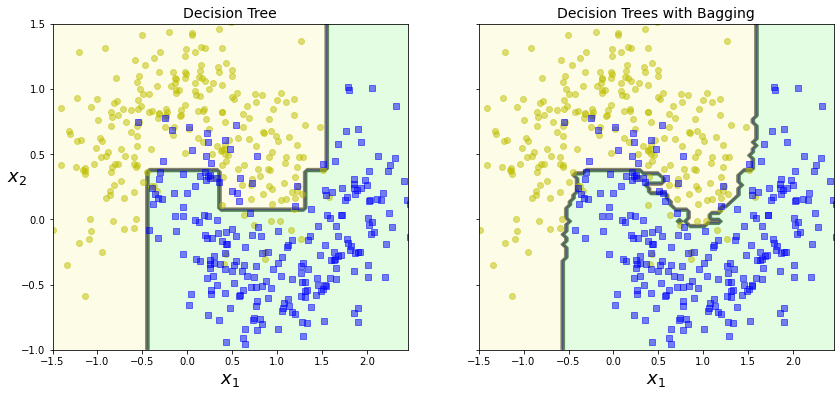

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

El ensamble tiene un *bias* similar al árbol individual, pero hay menos varianza (comete el mismo número de errores en los datos de entrenamiento, pero el límite de decisión es menos irregular).

##### Evaluación *out-of-bag*

Con *bagging* es posible tener la misma instancia usada varias veces en el entrenamiento de un predictor, mientras para otro no está usada ni una vez.

![](figures_ensamble/fig_wiki_oob.jpg)

Por defect, `BaggingClassifier` toma $m$ instancias del conjunto de entrenamiento, con reemplazo (`bootstrap=True`), donde $m$ es el tamaño del conjunto.

$\sim 63$% de las instancias están usadas, en promedio, para cada predictor. Los demás $37$% se llaman instancias *out-of-bag* (oob).

Cada predictor tendrá un conjunto de instancias "oob" diferente.

Podemos usar las instancias "oob" para evaluación del modelo, en vez de usar un conjunto de validación, con `oob_score=True`.

In [26]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True)

In [27]:
bag_clf.oob_score_

0.9013333333333333

Esperamos un *accuracy* de 90.1% en el conjunto de preuba...

In [28]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

También se puede obtener la función de decisión "oob" para cada instancia de entrenamiento.

En este caso el clasificador de base (`DecisionTreeClassifier`) tiene un método `predict_proba()`, así que la función de decisión retorna las probabilidades de cada clase para cada instancia de entrenamiento.

In [29]:
bag_clf.oob_decision_function_

array([[0.37096774, 0.62903226],
       [0.32994924, 0.67005076],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.07978723, 0.92021277],
       [0.32608696, 0.67391304],
       [0.01507538, 0.98492462],
       [0.99438202, 0.00561798],
       [0.98351648, 0.01648352],
       [0.79096045, 0.20903955],
       [0.        , 1.        ],
       [0.75      , 0.25      ],
       [0.8358209 , 0.1641791 ],
       [0.95652174, 0.04347826],
       [0.07253886, 0.92746114],
       [0.        , 1.        ],
       [0.98947368, 0.01052632],
       [0.93714286, 0.06285714],
       [0.99453552, 0.00546448],
       [0.02030457, 0.97969543],
       [0.31578947, 0.68421053],
       [0.90697674, 0.09302326],
       [1.        , 0.        ],
       [0.98477157, 0.01522843],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.66497462, 0.33502538],
       [0.

##### Parches aleatorios y sub-espacios aleatorios (random patches, random subspaces)

Se puede elegir los *features* usados en un `BaggingClassifier` aleatoriamente también. Hay dos hiperparámetros:

* `max_features`
* `bootstrap_features`

Estos son equivalentes a `max_samples` y `bootstrap` pero para los *features* en vez de las instancias.

Entonces, cada predictor está entrenado con un subconjunto aleatorio diferente de los *features*. Este es útil cuando los datos tienen muchas dimensiones.

* Parches aleatorios (*random patches*) corresponde a usar *bagging* para instancias y *features*
* Subespacios aleatorios (*random subspaces*) corresponde a usar todas las instancias de entrenamiento pero aplicar *bagging* a los *features* (`bootstrap=False`, `max_samples=1.0`, `bootstrap_features=True`, `max_features=x` donde `x < 1.0`)

Usando subconjuntos de *features* tenemos aún más diversidad de predictores, así que el *bias* aumenta y la varianza disminuye.

### Random Forests

Ya hemos usado un *random forest* (ensamble de árboles de decisión, usualmente ocupando *bagging* con `max_samples` igual al tamaño del conjunto de entrenamiento).

En vez de usar `BaggingClassifier` tenemos `RandomForestClassifier` que es más optimizado (también hay `RandomForestRegressor` para regresión).

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [15]:
y_pred_rf

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

En un *random forest* un nodo está dividido en cada árbol usando el mejor *feature* en un conjunto aleatorio de *features*.

Así que un *random forest* tiene más aleatoriedad que un árbol de decisión individual $\Rightarrow$ más *bias*, menos varianza.

#### Extra-Trees

Se puede usar umbrales aleatorios para cada *feature* en la división de los nodos, en vez de usar el mejor umbral posible (como lo que pasa con un árbol de decisión normal).

Un *random forest* así se llama un ensamble de *extremely randomized trees* (*Extra-Trees*).

En Scikit-Learn está disponible con `ExtraTreesClassifier`.

Este modelo de nuevo aumenta el *bias* pero reduce la varianza.

#### Importancia de los *features*

Con un *random forest* se puede determinar la importancia relativa de cada *feature*.

La importancia de un *feature* está dada por cuanto está reducido la **impureza** (en promedio, sobre todos los árboles del bosque) por nodos que utilizan ese *feature*.

El promedio es un promedio ponderado, donde el peso de cada nodo es igual al número de instancias de entrenamiento asociado.

Scikit-Learn calcula esta importancia automaticamente para cada *feature* después del entrenamiento, y normaliza los resultados tal que $\sum_{i=0}^{n} I_i = 1$, donde $I_i$ es la importancia de *feature* $i$.

Se puede acceder a esta información con la variable `feature_importances_`.

##### Ejemplo con los dígitos de MNIST

In [16]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [17]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [18]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

[Text(1, 0.0, 'No importante'),
 Text(1, 0.009791489757332336, 'Muy importante')]

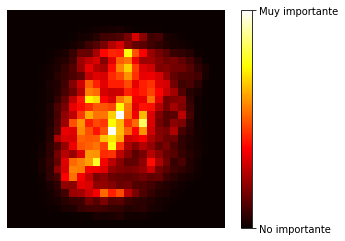

In [19]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['No importante', 'Muy importante'])

### Boosting

*Boosting* se refiere a cualquier método de ensamble que combina varios modelos débiles en un modelo fuerte.

La idea general es entrenar los modelos secuencialmente, cada modelo intentando a "corregir" los errores del modelo anterior.

Dos métodos más populares:
* *AdaBoost* (*Adaptive Boosting*)
* *Gradient Boosting*

### AdaBoost

Ejemplo de clasificación:

1. El primer clasificador está entrenado y realiza predicciones (clasificaciones) en los datos de entrenamiento.
2. Los pesos de las instancias mal clasificadas están aumentados.
3. El segundo clasificador está entrenado usando los datos con los nuevos pesos, realiza predicciones.
4. Los pesos de las instancias mal clasificadas están aumentados de nuevo, etc...

![](figures_ensamble/fig7-7.png)

Como ejemplo, abajo vemos los límites de decisión de $5$ predictores consecutivos en el conjunto de *moons* (cada predictor es un clasificador de SVM con mucha regularización y un kernel de RBF).

El primer clasificador comete muchos errores, los pesos de estas instancias están *boosted*, el segundo clasificador es mejor, etc...

| ![](figures_ensamble/fig7-8.png) |
|----------------------------------|
| Dos secuencias de *AdaBoost*. En la figura a la derecha las instancias mal clasificadas tienen la mitad del peso aplicado a la izquierda. |

Una vez que todos los predictores estén entrenados, el ensamble realiza predicciones en una manera similar a *bagging* o *pasting*, pero los predictores tienen pesos distintos según su precisión en los datos ponderados de entrenamiento.

Una desvantaja importante: no se puede paralelizar el método, ya que cada predictor requiere el resultado del predictor anterior.

#### En mas detalles...

Definimos un vector de pesos para todas las instancias de entrenamiento $w^{(i)}$.

Inicializamos estos pesos a $1/m$, donde $m$ es el número de instancias.

Calculamos la taza ponderada de error del $j$-esima predictor así:

$$r_j = \frac{1}{\sum_{i=1}^m w^{(i)}} \left( \underset{\hat{y}^{(i)}_j \neq y^{(i)}}{\sum_{i=1}^m w^{(i)}} \right)$$

donde $\hat{y}^{(i)}_j$ es la predicción del $j$-esima predictor para la $i$-esima instancia.

El peso del predictor $\alpha_j$ está dado por:

$$\alpha_j = \eta \log \frac{1-r_j}{r_j}$$

donde $\eta$ es la taza de aprendizaje (por defect igual a $1$) para el proceso de *boosting*. (Hay similitudes con descenso por gradiente...)

Si los predicciones del predictor son aleatorios, $\alpha_j \approx 0$, si son siempre incorrectos (peor que aleatorio) $\alpha_j < 0$.

Ahora, los pesos de las instancias están actualizados:

$$w^{(i)} = \begin{cases} w^{(i)} & \hat{y}^{(i)}_j = y^{(i)} \\ w^{(i)} \exp(\alpha_j) & \hat{y}^{(i)}_j \neq y^{(i)} \end{cases}$$

Después, todos los pesos de las instancias están normalizados (dividido por $\sum_{i=1}^m w^{(i)}$).

Finalmente, un nuevo predictor está entrenado con los nuevos valores de $w^{(i)}$, calculamos $\alpha$ para el nuevo predictor, actualizamos los valores de $w^{(i)}$ y repetimos el proceso.

Para realizar predicciones, *AdaBoost* calcula las predicciones de todos los predictores y aplica los pesos $\alpha_j$. La clase predicha es la que recibe la mayoría de votos ponderados:

$$\hat{y}(\boldsymbol{x}) = \underset{k}{\text{argmax}} \underset{\hat{y}_j(\boldsymbol{x}) = k}{\sum_{j=1}^N} \alpha_j$$

donde $N$ es el número de predictores.

Scikit-Learn ocupa una versión multiclase de *AdaBoost* que se llama *SAMME* (*Stagewise Additive Modeling using a Multiclass Exponential loss function*).

Con dos clases, SAMME es equivalente a *AdaBoost*.

Si los predictores pueden estimar probabilidades para las clases (tienen el método `predict_proba()`) Scikit-Learn puede ocupar una variante de SAMME que se llama *SAMME.R* que utiliza estas probabilidades y típicamente funciona mejor.

En el ejemplo abajo usamos un tocón de decisión (*decision stump*, un árbol de decisión con `max_depth=1`: un nodo de decisión y dos nodos de hoja).

In [32]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             n_estimators=200,
                             algorithm="SAMME.R",
                             learning_rate=0.5)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

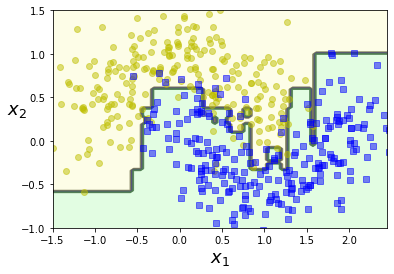

In [33]:
plot_decision_boundary(ada_clf, X, y)

### Gradient Boosting

En este método la idea es ajustar el nuevo predictor a los errores residuos cometidos por el predictor anterior.

Como ejemplo, consideramos regresión con árboles de decisión.

In [34]:
# Datos cuadráticos

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [36]:
y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [37]:
y3 = y2 - tree_reg2.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [38]:
X_new = np.array([[0.8]])
y_pred = np.sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

/tmp/ipykernel_23407/1684835290.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y_pred = np.sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


In [39]:
y_pred

array([0.75026781])

In [40]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

/tmp/ipykernel_23407/3820871828.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
/tmp/ipykernel_23407/3820871828.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
/tmp/ipykernel_23407/3820871828.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
/tmp/ipykernel_23407/3820871828.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in 

Text(0, 0.5, '$y$')

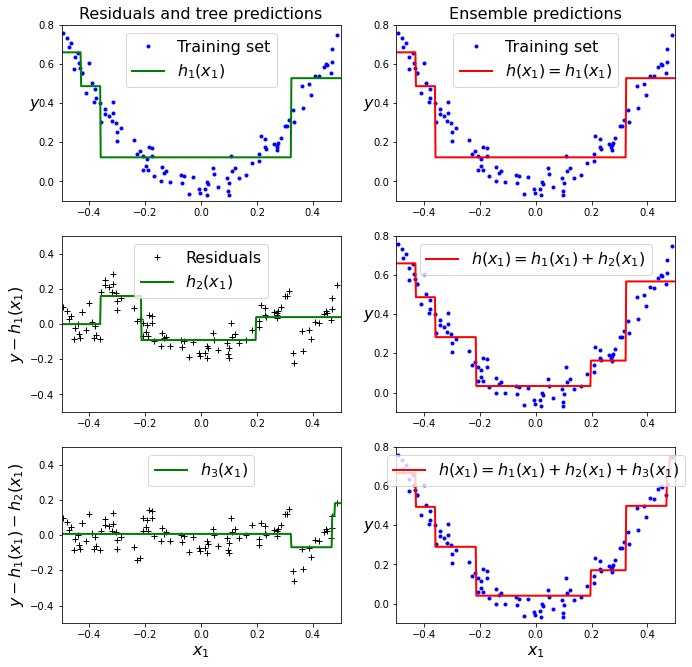

In [41]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

Es más fácil usar `GradientBoostingRegressor` del Scikit-Learn para implementar este tipo de *boosting*. Funciona con árboles de decisión, así tiene hiperparámetros relevantes para los árboles.

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [48]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

/tmp/ipykernel_23407/3820871828.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
/tmp/ipykernel_23407/3820871828.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)


Text(0.5, 0, '$x_1$')

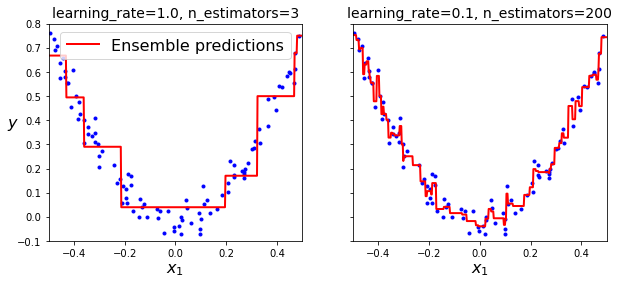

In [49]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

La taza de aprendizaje (*learning rate*) aplica un factor a la contribución de cada árbol.

Si toma un valor pequeño, necesitamos más árboles para ajustar bien a los datos, pero las predicciones suelen generalizar mejor (esta es una técnica de regularización que se llama *shrinkage*).

En la figura arriba, el modelo a la izquierda no tiene suficientes árboles (*underfitting*), mientras el modelo a la derecha tiene demasiados (*overfitting*).

Una forma de encontrar el número óptimo de árboles es con *early stopping*

El método `staged_predict()` ejecuta una iteración sobre las predicciones del ensamble en cada etapa de entrenamiento (con $1$ árbol, $2$ árboles, etc.)

El código abajo entrena un ensamble de *Gradient Boosted Regression Trees* con $120$ árboles, mide el error de validación en cada etapa de entrenamiento para encontrar el número óptimo de árboles, y después entrena otro ensamble GBRT con este número de árboles.

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=33)

In [51]:
min_error = np.min(errors)

/tmp/ipykernel_23407/3820871828.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)


Text(0.5, 0, '$x_1$')

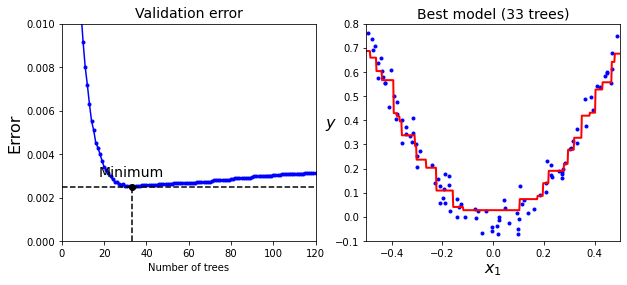

In [52]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

### Stacking

El último método de ensamble que veremos se llama *stacking* (*stacked generalisation*).

La idea es usar un modelo para agregar las predicciones de los predictores en el ensamble (en vez de elegir algo *a priori*).

![](figures_ensamble/fig7-12.png)

Para entrenar la "licuadora" (*blender*) se puede usar un conjunto de *hold-out*.

Primero, el conjunto de entrenamiento está dividido en dos subconjuntos. El primero está usado para entrenar los predictors en la primera capa.

![](figures_ensamble/fig7-13.png)

Después, los predictores de la primera capa realizan predicciones en el conjunto $2$ (el de *hold-out*).

Así aseguramos que las predicciones son "limpias" ya que los predictores no vieron estos datos en su entrenamiento.

Ahora, para cada instancia en el conjunto de *hold-out* hay $3$ valores predichos. Creamos un nuevo conjunto de entrenamiento con estas predicciones como *features* de entrada (por lo tanto, es un conjunto tridimensional), y manteniendo los valores de *target*.

La "licuadora" está entrenada en este nuevo conjunto para que aprenda predecir los valores de *target* usando las predicciones de la primera capa.

![](figures_ensamble/fig7-14.png)

Es posible entrenar varias "licuadoras", y así tener una capa de "licuadoras".

Para hacer eso, hay que dividir el conjunto de entrenamiento en $3$ subconjuntos:

* El primero es para entrenar la primera capa.
* El segundo es para crear el conjunto usado para entrenar la segunda capa (con las predicciones de la primera capa).
* El tercero es para crear el conjunto usado para entrenar la tercera capa (con las predicciones de la segunda capa).

Una vez completado el entrenamiento, una predicción para una nueva instancia se puede obtener pasando a través de cada capa secuencialmente.

![](figures_ensamble/fig7-15.png)

Scikit-Learn no tiene una implementación de *stacking*, pero no es muy difícil implementar.